# Gaussian Processes with Autogradients

So Gaussian processes are a very popular machine learning algorithm for regression. They have useful properties due to the having flexible kernels as well as access to the derivative. However, they can be a bit difficult to program because there is an optimization step. In either case, the autogradient function should be useful in many aspects and I will attempt to use that functionality for the following parts of the GP Algorithm:
* Predictive Mean
* Negative Log Maximum Likelihood
* Predictive Variance

My code will be a rough representation of a few repos:

* Sklearn - [GaussianProcessRegressor](https://github.com/scikit-learn/scikit-learn/blob/f0ab589f/sklearn/gaussian_process/gpr.py)
* AMOGAPE - [AMOGAPE](https://github.com/dhsvendsen/AMOGAPE/blob/master/mintGP.py)
* Autograd - [gaussian process](https://github.com/geostk/autograd/blob/master/examples/gaussian_process.py)

I will have a class implementation based on the scikit-learn framework.

In [11]:
import autograd
import autograd.numpy as np
from autograd import value_and_grad
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.gaussian_process.kernels import (_check_length_scale)
from sklearn.metrics.pairwise import check_pairwise_arrays
from sklearn.utils import check_random_state
from sklearn.utils.validation import check_X_y, check_array
from scipy.spatial.distance import pdist, cdist, squareform
import matplotlib.pyplot as plt
from scipy.optimize import minimize
%matplotlib inline

## Kernel Function (RBF)

c

In [2]:
def rbf_covariance(

SyntaxError: unexpected EOF while parsing (<ipython-input-2-38d366d1c38a>, line 1)

In [ ]:
# class GPRegressor(BaseEstimator, RegressorMixin):
#     def __init__(self, kernel=None, jitter=1e-09, normalize_y=False, 
#                  random_state=None):
#         self.kernel = kernel
#         self.jitter = jitter
#         self.normalize_y = normalize_y
#         self.random_state = random_state
        
#     def fit(self, X, y):
        
#         # Get the kernel function
#         if self.kernel is None:
#             self.kernel_ = ConstantKernel(1.0, constant_value_bounds='fixed') \
#                 * RBF(1.0, length_scale_bounds='fixed') \
#                 + WhiteKernel(0.01, length_scale_bounds='fixed')
        
#         # Standard Checks for inputs
#         X, y = check_X_y(X, y, multi_output=True, y_numeric=True)
        
#         if self.normalize_y:
#             # get mean of labels
#             self.y_train_mean = np.mean(y, axis=0)
            
#             # remove the mean from y
#             y -= self.y_train_mean
#         else:
#             self.y_train_mean = np.zeros(1)
        
        
#         # -------------------------------------------
#         # Gradient Descent
#         # -------------------------------------------
        
#         return self
    
#     def log_marginal_likelihood(self, theta=None, eval_gradient=False):
#         """Returns the log-marginal likelihood of theta for the training data.
        
#         Parameters
#         ----------
#         theta : array-like, shape = (n_kernel_params)
#             The kernel params for the log-marginal likelihood is evaluted. 
            
#         eval_gradient : bool, default: False
#             If true, the gradient of the log-marginal likelihood with respect to the
#             kernel hyperparameters at the position theta is returned additionally.
#             If true, theta must not be none.
            
#         Returns
#         -------
#         log_likelihood : float
#             Log-marginal likelihood of theta for training data
        
#         log_likelihood_gradient : array, shape = (n_kernel_params,), optional
#             Gradient of the log-marginal likelihood with respect to the kernel 
#             hyperparameters at position theta.
#             Only returned when eval_gradient is True.
#         """
#         if theta is None:
#             if eval_gradient:
#                 raise ValueError(
#                     "Gradient can only be evaluated for theta!=None."
#                 )
#             return self.log_marginal_likelihood_value_
        
#         kernel = self.kernel_.clone_with_theta(theta)
        
#         if eval_gradient:
#             K, K_gradient = kernel(self.X_train_, eval_gradient=True)
#         else:
#             K = kernel(self.X_train)
            
#         K[np.diag_indices_from(K)] += self.alpha
        
#         try:
#             L = cholesky(K, lower=True)
#         except np.linalg.LinAlgError:
#             return (-np.inf, np.zeros_like(theta)) if eval_gradient else -np.inf
        
#         # multidimensional output of self.y_train_
#         y_train = self.y_train_
#         if y_train.ndim == 1:
#             y_train = y_train[:, np.newaxis]
            
#         # -------------------------------------
#         # Marginal Log Likelihood Calculation
#         # -------------------------------------
#         alpha = cho_solve((L, true), y_train)
        
#         log_likelihood_dims = -0.5 * np.einsum("ik,ik->k", y_train, alpha) # term 1
#         log_likelihood_dims -= np.log(np.diag(L)).sum()                    # term 2
#         log_likelihood_dims -= (K.shape[0] / 2) * np.log(2 * np.pi)        # term 3
#         log_likelihood = log_likelihood_dims.sum(-1)
        
#         if eval_gradient:
#             tmp = np.einsum("ik,jk->ijk", alpha, alpha)  # k:output-dimension
#             tmp -= cho_solve((L, True), np.eye(K.shape[0]))[:, :, np.newaxis]
            
#             log_likelihood_gradient_dims = \
#                 0.5 * np.einsum("ijl,ijk->kl", tmp, K_gradient)
            
#             log_likelihood_gradient = log_likelihood_gradient_dims.sum(-1)
            
#             return log_likelihood, log_likelihood_gradient
#         else:
#             return log_likelihood
        
        
        
#         if eval_gradient:
#             return log_likelihood, log_likelihood_gradient
#         else:
#             return log_likelihood

In [12]:
import autograd.scipy.stats.multivariate_normal as mvn

class GaussianProcessRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, kernel='rbf', jitter=1e-09, random_state=None):
        self.kernel = kernel
        self.jitter = jitter
        self.random_state = random_state

    def fit(self, X, y):
        
        # standardize the data
        self.X = X
        self.Y = y
        
        # initialize parameters
        noise_scale = 0.01
        length_scale = 10.0
        theta0 = np.array([noise_scale, length_scale])
        bounds = ((1e-10, 1e10), (1e-10, 1e10))
        
        # define objective function: negative log marginal likelihood
        objective = lambda theta0: -self.log_marginal_likelihood(theta0)
        
        # minimize negative log marginal likelihood
        cov_params = minimize(value_and_grad(objective), theta0, jac=True, args=(), method='L-BFGS-B', bounds=bounds)
        
        # get params
        self.noise_scale, self.length_scale = self._unpack_kernel_params(cov_params.x)
        
        # calculate the weights
        K = self.K(self.X, length_scale=self.length_scale)
        self.L = np.linalg.cholesky(K + noise_scale * np.eye(K.shape[0]))
        weights =  np.linalg.solve(self.L.T, np.linalg.solve(self.L, self.Y))
        self.weights_ = weights
        
        return self
    
#     def K(self, X, Y=None, length_scale=1.0, scale=1.0):
        
#         scale_term = - 0.5 / np.power(length_scale, 2)
        
#         dists

#         if Y is None:

#             dists = pdist(X, metric='sqeuclidean')

#             K = np.exp(scale_term * dists)

#             K = squareform(K)

#             np.fill_diagonal(K, 1)

#         else:

#             dists = cdist(X, Y, metric='sqeuclidean')

#             K = np.exp(scale_term  * dists) 


#         return K
    def K(self, X, Y=None, length_scale=1.0, scale=1.0):
        
#         scale_term = - 0.5 / np.power(length_scale, 2)
        
        diffs = np.expand_dims(X / length_scales, 1) \
            - np.expanddims(Y / length_scales, 0)


        return np.exp(-0.5 * np.sum(diffs**2, axis=2))
    
    def predict(self, X, return_std=None):
        
        K = self.K(X, self.X, length_scale=self.length_scale)
        
        predictions = np.dot(K, self.weights_)
        if not return_std:
            return predictions
        else:            
            K_test = rbf_covariance(X, length_scale=self.length_scale)
            v = np.linalg.solve(self.L, K.T)
            std_dev = np.sqrt(self.noise_scale + np.diag(K_test - np.dot(v.T, v)))
            return predictions, std_dev
    
    def pred_grad(self, X):
        
        mu = lambda x: self.predict(x, return_std=False)
        auto_grad = autograd.grad(mu)
        
        return auto_grad(X)
    
    def _unpack_kernel_params(self, params):
        return params[0], params[1:]
    
    def log_marginal_likelihood(self, params):
        
        x_train = self.X
        y_train = self.Y
        
        # unpack the parameters
        noise_scale, length_scale = self._unpack_kernel_params(params)
        
        # calculate the covariance matrix
        K = self.K(x_train, length_scale=length_scale)
        K_chol = K + noise_scale * np.eye(K.shape[0])
#         K += self.jitter * np.eye(K.shape[0])
        
        # Solve the cholesky
        print(K.shape)
        try:
            self.L = np.linalg.cholesky(K_chol)
            
        except np.linalg.LinAlgError:
            return -np.inf
                
        if y_train.ndim == 1:
            y_train = y_train[:, np.newaxis]
        
        # get the weights
        alpha = np.linalg.solve(self.L.T, np.linalg.solve(self.L, y_train))
        
        # compute log-likelihood
        log_likelihood_dims = -0.5 * np.einsum('ik,ik->k', y_train, alpha)
        log_likelihood_dims -= np.log(np.diag(self.L)).sum()
        log_likelihood_dims -= (K.shape[0] / 2 ) * np.log(2 * np.pi)
        
        log_likelihood = log_likelihood_dims.sum(-1)
        
        return log_likelihood
        

In [13]:
import autograd.scipy.stats.multivariate_normal as mvn

class GaussianProcessRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, kernel='rbf', jitter=1e-09, random_state=None):
        self.kernel = kernel
        self.jitter = jitter
        self.random_state = random_state

    def fit(self, X, y):
        
        # standardize the data
        self.X = X
        self.Y = y
        
        # initialize parameters
        noise_scale = 0.01
        length_scale = 10.0
        theta0 = np.array([noise_scale, length_scale])
        bounds = ((1e-10, 1e10), (1e-10, 1e10))
        
        # define objective function: negative log marginal likelihood
        objective = lambda theta0: -self.log_marginal_likelihood(theta0)
        
        # minimize negative log marginal likelihood
        cov_params = minimize(value_and_grad(objective), theta0, jac=True, args=(), method='L-BFGS-B', bounds=bounds)
        
        # get params
        self.noise_scale, self.length_scale = self._unpack_kernel_params(cov_params.x)
        
        # calculate the weights
        K = self.K(self.X, length_scale=self.length_scale)
        self.L = np.linalg.cholesky(K + noise_scale * np.eye(K.shape[0]))
        weights =  np.linalg.solve(self.L.T, np.linalg.solve(self.L, self.Y))
        self.weights_ = weights
        
        return self
    
    def K(self, X, Y=None, length_scale=1.0, scale=1.0):
        
        scale_term = - 0.5 / np.power(length_scale, 2)

        if Y is None:

            dists = pdist(X, metric='sqeuclidean')

            K = np.exp(scale_term * dists)

            K = squareform(K)

            np.fill_diagonal(K, 1)

        else:

            dists = cdist(X, Y, metric='sqeuclidean')

            K = np.exp(scale_term  * dists) 


        return K
    
    def predict(self, X, return_std=None):
        
        K = self.K(X, self.X, length_scale=self.length_scale)
        
        predictions = np.dot(K, self.weights_)
        if not return_std:
            return predictions
        else:            
            K_test = rbf_covariance(X, length_scale=self.length_scale)
            v = np.linalg.solve(self.L, K.T)
            std_dev = np.sqrt(self.noise_scale + np.diag(K_test - np.dot(v.T, v)))
            return predictions, std_dev
    
    def pred_grad(self, X):
        
        mu = lambda x: self.predict(x, return_std=False)
        auto_grad = autograd.grad(mu)
        
        return auto_grad(X)
    
    def _unpack_kernel_params(self, params):
        return params[0], params[1:]
    
    def log_marginal_likelihood(self, params):
        
        x_train = self.X
        y_train = self.Y
        
        # unpack the parameters
        noise_scale, length_scale = self._unpack_kernel_params(params)
        ktrain = self.K(x_train, length_scale=length_scale) 
        white_kern = noise_scale * np.eye(len(y_train))
        print(ktrain.shape, white_kern.shape)
        K = ktrain + white_kern
#         # calculate the covariance matrix
#         K = self.K(x_train, length_scale=length_scale)
#         K_chol = K + noise_scale * np.eye(K.shape[0])
# #         K += self.jitter * np.eye(K.shape[0])
        
#         # Solve the cholesky
#         print(K.shape)
#         try:
#             self.L = np.linalg.cholesky(K_chol)
            
#         except np.linalg.LinAlgError:
#             return -np.inf
                
#         if y_train.ndim == 1:
#             y_train = y_train[:, np.newaxis]
        
#         # get the weights
#         alpha = np.linalg.solve(self.L.T, np.linalg.solve(self.L, y_train))
        
#         # compute log-likelihood
#         log_likelihood_dims = -0.5 * np.einsum('ik,ik->k', y_train, alpha)
#         log_likelihood_dims -= np.log(np.diag(self.L)).sum()
#         log_likelihood_dims -= (K.shape[0] / 2 ) * np.log(2 * np.pi)
        
#         log_likelihood = log_likelihood_dims.sum(-1)
        tmp = mvn.logpdf(y_train, 0.0, Kernel)
        print(tmp)
        return tmp
        

### Data

X training data: (30, 1)
X testing data: (30, 1)


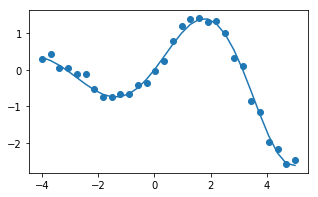

In [14]:
# get some toy data
d_dimensions = 1
n_samples = 20
noise_std = 0.1
seed = 123
rs = np.random.RandomState(seed)

n_train = 30
n_test = 30
xtrain = np.linspace(-4, 5, n_train).reshape(n_train, 1)
xtest = np.linspace(-4, 5, n_test).reshape(n_test, 1)
print('X training data:', xtrain.shape)
print('X testing data:', xtest.shape)


# Labels
f = lambda x: np.sin(x) * np.exp(0.2 * x)
ytrain = f(xtrain) + noise_std * np.random.randn(n_train, 1)
ytest = f(xtest)
# Plot the function
fig, ax = plt.subplots(figsize=(5, 3))

ax.scatter(xtrain, ytrain)
ax.plot(xtest, ytest)

plt.show()



### Test Function

In [15]:
# Initialize the model
gp_model = GaussianProcessRegressor(random_state=seed)

# fit the gp model to the inputs and targets
gp_model.fit(xtrain, ytrain)

y_pred, sigma = gp_model.predict(xtest, return_std=True)
# print(mu_der)
# tmp = y_pred.astype()
# print(tmp)
fig, ax = plt.subplots()

# ax.scatter(xtrain, ytrain)
ax.scatter(xtrain, ytrain)
ax.plot(xtest, y_pred)
ax.plot(xtest, mu_der)
plt.show()

(30, 30) (30, 30)


AttributeError: _trace

In [1]:
# Initialize the model
gp_model = GaussianProcessRegressor(random_state=seed)

# fit the gp model to the inputs and targets
gp_model.fit(xtrain, ytrain)


mu = lambda x: gp_model.predict(x)
y_pred = mu(xtest)
print(y_pred.shape)
auto_grad = autograd.grad(mu)

tmp = auto_grad(xtest)

NameError: name 'GaussianProcessRegressor' is not defined

In [112]:
import autograd.numpy as np   # Thinly-wrapped version of Numpy
from autograd import grad

def taylor_sine(x):  # Taylor approximation to sine function
    ans = currterm = x
    i = 0
    while np.abs(currterm) > 0.001:
        currterm = -currterm * x**2 / ((2 * i + 3) * (2 * i + 2))
        ans = ans + currterm
        i += 1
    return ans

grad_sine = grad(taylor_sine)
print("Gradient of sin(pi) is", grad_sine(np.pi))
print()

Initial loss: 2.772588722239781
Trained loss: 1.067270675787016


In [114]:
print(training_gradient_fun)

<function unary_to_nary.<locals>.nary_operator.<locals>.nary_f at 0x7f6f8ecac0d0>


In [9]:
from __future__ import absolute_import
from __future__ import print_function
import matplotlib.pyplot as plt

import autograd.numpy as np
import autograd.numpy.random as npr
from autograd.numpy.linalg import solve
import autograd.scipy.stats.multivariate_normal as mvn
from autograd import value_and_grad
from scipy.optimize import minimize


def make_gp_funs(cov_func, num_cov_params):
    """Functions that perform Gaussian process regression.
       cov_func has signature (cov_params, x, x')"""

    def unpack_kernel_params(params):
        mean        = params[0]
        cov_params  = params[2:]
        noise_scale = np.exp(params[1]) + 0.0001
        return mean, cov_params, noise_scale

    def predict(params, x, y, xstar):
        """Returns the predictive mean and covariance at locations xstar,
           of the latent function value f (without observation noise)."""
        mean, cov_params, noise_scale = unpack_kernel_params(params)
        cov_f_f = cov_func(cov_params, xstar, xstar)
        cov_y_f = cov_func(cov_params, x, xstar)
        cov_y_y = cov_func(cov_params, x, x) + noise_scale * np.eye(len(y))
        pred_mean = mean +   np.dot(solve(cov_y_y, cov_y_f).T, y - mean)
        pred_cov = cov_f_f - np.dot(solve(cov_y_y, cov_y_f).T, cov_y_f)
        return pred_mean, pred_cov

    def log_marginal_likelihood(params, x, y):
        mean, cov_params, noise_scale = unpack_kernel_params(params)
        cov_y_y = cov_func(cov_params, x, x) + noise_scale * np.eye(len(y))
        prior_mean = mean * np.ones(len(y))
        log_max = mvn.logpdf(y, prior_mean, cov_y_y)
        print(log_max)
        return log_max

    return num_cov_params + 2, predict, log_marginal_likelihood

# Define an example covariance function.
def rbf_covariance(kernel_params, x, xp):
    output_scale = np.exp(kernel_params[0])
    lengthscales = np.exp(kernel_params[1:])
    diffs = np.expand_dims(x /lengthscales, 1)\
          - np.expand_dims(xp/lengthscales, 0)
    return output_scale * np.exp(-0.5 * np.sum(diffs**2, axis=2))


def build_toy_dataset(D=1, n_data=20, noise_std=0.1):
    rs = npr.RandomState(0)
    inputs  = np.concatenate([np.linspace(0, 3, num=n_data/2),
                              np.linspace(6, 8, num=n_data/2)])
    targets = (np.cos(inputs) + rs.randn(n_data) * noise_std) / 2.0
    inputs = (inputs - 4.0) / 2.0
    inputs  = inputs.reshape((len(inputs), D))
    return inputs, targets


def callback(params):
    print("Log likelihood {}".format(-objective(params)))
    plt.cla()

    # Show posterior marginals.
    plot_xs = np.reshape(np.linspace(-7, 7, 300), (300,1))
    pred_mean, pred_cov = predict(params, X, y, plot_xs)
    marg_std = np.sqrt(np.diag(pred_cov))
    ax.plot(plot_xs, pred_mean, 'b')
    ax.fill(np.concatenate([plot_xs, plot_xs[::-1]]),
            np.concatenate([pred_mean - 1.96 * marg_std,
                           (pred_mean + 1.96 * marg_std)[::-1]]),
            alpha=.15, fc='Blue', ec='None')

    # Show samples from posterior.
    rs = npr.RandomState(0)
    sampled_funcs = rs.multivariate_normal(pred_mean, pred_cov, size=10)
    ax.plot(plot_xs, sampled_funcs.T)


    ax.plot(X, y, 'kx')
    ax.set_ylim([-1.5, 1.5])
    ax.set_xticks([])
    ax.set_yticks([])
    plt.draw()
    plt.pause(1.0/60.0)

In [10]:


D = 1

# Build model and objective function.
num_params, predict, log_marginal_likelihood = \
    make_gp_funs(rbf_covariance, num_cov_params=D + 1)

X, y = build_toy_dataset(D=D)
objective = lambda params: -log_marginal_likelihood(params, X, y)



# Initialize covariance parameters
rs = npr.RandomState(0)
init_params = 0.1 * rs.randn(num_params)

print("Optimizing covariance parameters...")
cov_params = minimize(value_and_grad(objective), init_params, jac=True,
                      method='CG')


Optimizing covariance parameters...
Autograd ArrayBox with value -22.415047313431167
Autograd ArrayBox with value -22.415047313431167
Autograd ArrayBox with value -31.027858408194493
Autograd ArrayBox with value -23.16615895604356
Autograd ArrayBox with value -22.483631947480745
Autograd ArrayBox with value -22.421337554524072
Autograd ArrayBox with value -22.415624457696325
Autograd ArrayBox with value -22.415100269737973
Autograd ArrayBox with value -22.415052172493635
Autograd ArrayBox with value -22.415047759279766
Autograd ArrayBox with value -22.415047354340498
Autograd ArrayBox with value -22.41504731718485
Autograd ArrayBox with value -22.415047313775595
Autograd ArrayBox with value -22.41504731346277
Autograd ArrayBox with value -22.415047313434062
Autograd ArrayBox with value -22.415047313431437
Autograd ArrayBox with value -22.415047313431195
Autograd ArrayBox with value -22.415047313431167
Autograd ArrayBox with value -22.41504731343117
Autograd ArrayBox with value -22.4150

In [105]:
print(predict(X, y, xstar))

NameError: name 'xstar' is not defined

In [152]:
# Build model and objective function.
num_params, predict, log_marginal_likelihood = \
    make_gp_funs(rbf_covariance, num_cov_params=D + 1)

X, y = build_toy_dataset(D=D)
objective = lambda params: -log_marginal_likelihood(params, X, y)

print(objective(init_params))

-22.415047313431167
22.415047313431167
